In [32]:
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras
import matplotlib.pyplot as plt

In [10]:
Data = loadmat('data/egypt_data/preprocessed data/all4years_zeros_shore_data.mat')["Values"]

In [3]:
area = 60
timeSteps= 16

In [12]:
print(Data.shape)
#3years = 8760, 4years = 11688
Data = Data.reshape(11688,139,82,3)
print(Data.shape)

data = Data[:,:area,:area,:]
print(data.shape)

(11688, 11398, 3)
(11688, 139, 82, 3)
(11688, 60, 60, 3)


In [13]:
train_data = data[:10000]
val_data = data[10000:11000]
test_data = data[11000:]
print(data.shape)


def prepare_data(data, steps):
    x, y = [], []
    for i in range(len(data)-steps-1):
        x.append(data[i:(i+steps)])
        y.append(data[i+steps][:,:,0])  # I WILL PREDICT FEATURE 0 ONLY(HEIGHT)
    return np.array(x), np.array(y)

x_train, y_train = prepare_data(train_data, 16)
x_val, y_val = prepare_data(val_data, 16)
x_test, y_test = prepare_data(test_data, 16)



(11688, 60, 60, 3)


In [33]:
def unet_model(input_shape):
    inputs = Input(input_shape)
    
    #DOWN > i used TimeDistributed to handle sequence
    conv1 = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(inputs)
    pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv1)

    conv2 = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(pool1)
    pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(conv2)

    #BOTTLENECK (i used ConvLSTM2D to handle sequences and reduce time dimension to 1 because i want to predict one time step ahead)
    convm = ConvLSTM2D(256, (3, 3), activation='relu', padding='same', return_sequences=False)(pool2)

    #uPSAMPLING
    up2 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(convm), conv2[:, -1]], axis=-1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)

    up1 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4), conv1[:, -1]], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)

    output = Conv2D(1, (1, 1), activation='linear')(conv5)

    model = Model(inputs=[inputs], outputs=[output])
    
    return model

In [35]:
input_shape = x_train.shape[1:]
model = unet_model(input_shape)

In [36]:
model.compile(optimizer='adam', loss='mse')

In [37]:
model.fit(x_train, y_train, epochs=4, verbose=1, validation_data=(x_val, y_val))


Epoch 1/4
312/312 [==============================] - 1673s 5s/step - loss: 0.0159 - val_loss: 0.0034
Epoch 2/4
312/312 [==============================] - 1699s 5s/step - loss: 0.0074 - val_loss: 0.0035
Epoch 3/4
312/312 [==============================] - 1690s 5s/step - loss: 0.0064 - val_loss: 0.0038
Epoch 4/4
312/312 [==============================] - 1835s 6s/step - loss: 0.0067 - val_loss: 0.0059


In [4]:
model.save(f'Egypt models/Simple_UNet_{area}.keras')

In [1]:
from tensorflow import keras
model = keras.models.load_model('Egypt models/Simple_UNet_60.keras')

In [40]:
test_loss = model.evaluate(x_test, y_test)
print('Test Loss: {}'.format(test_loss))

21/21 [==============================] - 30s 1s/step - loss: 0.0087
Test Loss: 0.008735363371670246


In [41]:
x_try = x_test[0].reshape(1,16,area,area,3)
y_try = y_test[0]
y_pred = model.predict(x_try).reshape(area,area)

1/1 [==============================] - 0s 484ms/step


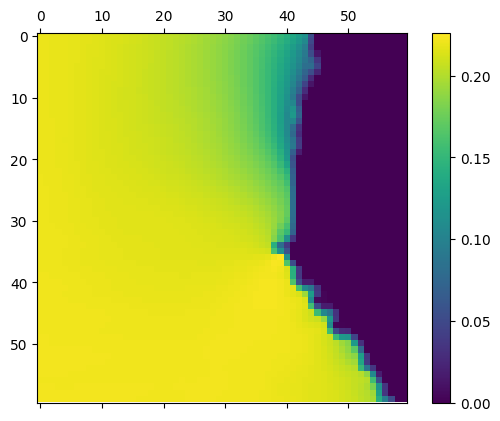

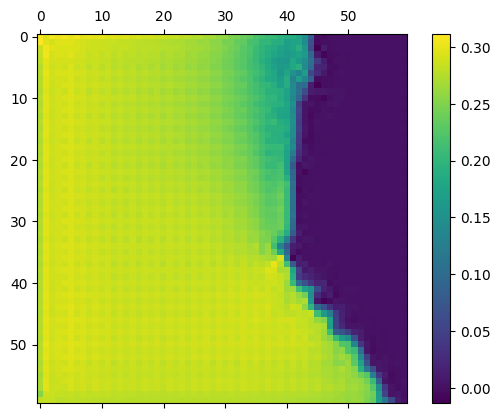

In [42]:
fig, ax = plt.subplots()
cax = ax.matshow(y_try)
fig.colorbar(cax)
plt.show()

fig, ax = plt.subplots()
cax = ax.matshow(y_pred)
fig.colorbar(cax)
plt.show()